# 1. 数据预处理

In [ ]:
import scanpy as sc
import os

input_dir = "./datasets/mel_data/"
adata = sc.read_h5ad(os.path.join(input_dir, "mel_adata.h5ad"))
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=5)
adata.obs['celltype'] = adata.obs.idxmax(axis=1)
cell_type_counts = adata.obs['celltype'].value_counts()  
low_count_types = cell_type_counts[cell_type_counts < 5].index  
adata = adata[~adata.obs['celltype'].isin(low_count_types)] 
genes_use = adata.var_names

In [2]:
adata

View of AnnData object with n_obs × n_vars = 287 × 12473
    obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T', 'celltype'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'

# 2. 训练数据生成

In [2]:
from utils.utils import getTopCorrPairs, calCorr
from utils.utils_read import getInteractionDB
import numpy as np
import pandas as pd
mapping = dict(zip(genes_use, range(len(genes_use))))
lr_db, pathways, rec_tg, tftg = getInteractionDB(genes_use, "Human")
genes_interest = np.unique(pathways.iloc[:, :2].values)

data_df = adata.to_df()[genes_interest]
print(data_df.shape)
corr = calCorr(data_df)
maps = dict(zip(genes_interest, range(len(genes_interest))))

links = pathways.iloc[:, :2].values
links = np.vectorize(maps.get)(links)
pathways['weight'] = corr.values[links[:, 0], links[:, 1]]
topCorrPairs = getTopCorrPairs(corr, 0.05)
top_pathways = pd.merge(pathways, topCorrPairs, left_on=pathways.columns.values.tolist()[:2], right_on=topCorrPairs.columns.values.tolist(), how="inner")
print(top_pathways.shape)


(287, 11522)
0.14149039426401294
(23050, 4)


## 基因初始嵌入生成

In [ ]:
from fastnode2vec import Node2Vec,Graph
genes_edges = tuple(map(tuple, links.tolist()))
graph = Graph(genes_edges,directed=False, weighted=False)
node2vec = Node2Vec(graph, dim=64, walk_length=100, window=10, p=2.0, q=0.5, workers=2)
node2vec.train(epochs=500)
emb = {str(node): node2vec.wv[node] for node in graph.node_names}

res = np.array([list(emb[str(i)]) for i in range(len(genes_interest))])
np.save(os.path.join(input_dir,"gene_interaction_graph.npy"), res)

# 3. 模型训练

In [ ]:
import torch
import random
from torch.optim import Adam
from sklearn.neighbors import kneighbors_graph
from utils.loader import StDataset, Ripplewalk_sampler
lr_rate = 1e-3
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
SEED = 1002
batch_size = 32
k = 8

np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

adata = adata[:, genes_interest]
clusters, counts = np.unique(adata.obs['celltype'], return_counts=True)

data = adata.X.A
gene_adj = np.vectorize(maps.get)(top_pathways.values[:, :2]).T
edge_gene = torch.from_numpy(gene_adj).long().to(device)

cell_graph = kneighbors_graph(adata.obsm["spatial"], n_neighbors=k, include_self=False)
dataset = StDataset(adata, cell_graph, adata.obs['celltype'])
loader = Ripplewalk_sampler(cell_graph, batchsize=batch_size,total_times=5)

In [ ]:
from model.torch_utils import CosineAnnealingWarmupRestarts
from model.DualViewModel import CGNet
value_nums = (data>0).sum(1)
max_exp_gene_num = (int) (max(value_nums))
embed_dim = 16
num_class = clusters.shape[0]
cell_embed_hidden_dim = 32
model = CGNet(data.shape[1], 
                64, 
                embed_dim,
                num_class, 
                lambda_pred=.4,
                lambda_cell = .25,
                lambda_gene = .25,
                lambda_recon = .10,
                path=os.path.join(input_dir, "gene_interaction_graph.npy")
                )
optimizer = Adam(model.parameters(), lr=lr_rate)
# learning rate scheduler
scheduler = CosineAnnealingWarmupRestarts(
    optimizer,
    first_cycle_steps=15,
    cycle_mult=1,
    max_lr=lr_rate,
    min_lr=1e-6,
    warmup_steps=5,
    gamma=0.9
)

In [5]:
from model.LossHistory import LossHistory
log_dir = './logs/molenoma/'
loss_history = LossHistory(log_dir, model)

In [ ]:
from tqdm import tqdm
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
Epoch = 200
n_train_batch = len(dataset) // batch_size
save_period = 100
model.train()
model = model.to(device)
edge_gene = edge_gene.to(device)
for epoch in tqdm(range(Epoch)):
    model.train()
    train_loss = 0
    train_loss_gene_adj = 0
    train_loss_cell_adj = 0
    train_loss_pred = 0
    train_loss_rec = 0
    # for batch_id, batch_x, batch_adj, batch_y in loader:
    for index in loader:
        batch_x, batch_adj, batch_y = dataset.get_batch(index)
        # print( batch_x.shape)
        batch_adj = torch.from_numpy(np.vstack(np.nonzero(batch_adj.A+batch_adj.A.T)))
        optimizer.zero_grad()
        batch_x = batch_x.to(device)
        batch_adj = batch_adj.to(device)
        batch_y = batch_y.to(device)
        out = model(batch_x, batch_adj, edge_gene, True, True)

        loss, loss_gene_adj, loss_cell_adj, loss_pred, loss_rec  = model.loss(out, batch_x, batch_y, batch_adj, edge_gene)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_loss_gene_adj += loss_gene_adj.item()
        train_loss_cell_adj += loss_cell_adj.item()
        train_loss_pred += loss_pred.item()
        train_loss_rec += loss_rec.item()
        
    train_loss = train_loss/n_train_batch
    train_loss_gene_adj = train_loss_gene_adj/n_train_batch
    train_loss_pred = train_loss_pred/n_train_batch
    train_loss_cell_adj = train_loss_cell_adj/n_train_batch
    train_loss_rec = train_loss_rec/n_train_batch
    scheduler.step()
    print('Epoch:' + str(epoch + 1) + '/' + str(Epoch)+ "\t\t"+ 'Train Loss: %.3f' % (train_loss))
    loss_history.append_loss(epoch + 1, train_loss, train_loss_gene_adj, train_loss_cell_adj, train_loss_pred, train_loss_rec )
    
    if (epoch + 1) % save_period == 0 or epoch + 1 == Epoch:
        torch.save(model.state_dict(),
                   os.path.join(log_dir, 'ep%03d-loss%.3f.pth' % (epoch + 1, train_loss)))
model.eval()

# 4. 模型可解释性-基因重要性分数

In [8]:
from utils.gradcam import GradCAM



grad_cam = GradCAM(model)

In [ ]:
from utils.loader import Ripplewalk_prediction

pre_loader = Ripplewalk_prediction(cell_graph, batchsize=128)
exp_mtx = adata.X

cell_importance = dict()
gene_importance = {}
for k in range(len(clusters)):
    cam, cell_cam, index = None, None, None
    for i in range(len(pre_loader)):
        cur_index = pre_loader[i]
        exp_batch = torch.FloatTensor(exp_mtx[cur_index].toarray()).to(device)
        batch_adj = cell_graph[cur_index][:, cur_index].toarray()
        batch_adj = torch.from_numpy(np.vstack(np.nonzero(batch_adj+batch_adj.T))).to(device)
        batch_cam, batch_cell_cam = grad_cam.generate_cam(exp_batch, batch_adj, edge_gene, k)
        if cam is None:
            cam = batch_cam
            cell_cam = batch_cell_cam
            index = cur_index
        else:
            cell_cam = np.concatenate([cell_cam, batch_cell_cam], axis=0)
            cam = np.concatenate([cam, batch_cam], axis=0)
            index = np.concatenate([index, cur_index], axis=0)
    cam = cam[np.argsort(index), :]
    cell_cam = cell_cam[np.argsort(index), :]
    index = index[np.argsort(index)]

    if index.shape[0]>adata.shape[0]:
        tmp = []
        cell_tmp = []
        for i in range(adata.shape[0]):
            cur_tmp = cam[index==i, :].mean(axis=0)
            cur_cell_tmp = cell_cam[index==i, :].mean(axis=0)
            tmp.append(cur_tmp)
            cell_tmp.append(cur_cell_tmp)
        cam = np.array(tmp)   
        cell_cam = np.array(cell_tmp)   
    
    gene_importance[clusters[k]] = cam
    cell_importance[clusters[k]] = cell_cam

(1.75, 29.25, 6.0, 28.0)

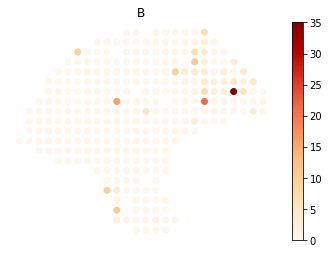

In [10]:
import matplotlib.pyplot as plt

adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]
celltype = 'B'
plt.scatter(adata.obs['X'], adata.obs['Y'], 
            c=cell_importance[celltype], cmap = 'OrRd')
plt.colorbar()
plt.title(celltype)
plt.axis("off")

# 5. 细胞通讯分析

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
data = adata.X.A
exp_batch = torch.FloatTensor(data[[0]]).to(device)
edge_gene = edge_gene.to(device)
with torch.no_grad():
    gene_feture, gene_emb = model.get_gene_embedding(exp_batch, edge_gene)
gene_feture = gene_feture.detach().cpu()
gene_emb = gene_emb.detach().cpu()

    

In [ ]:
from utils.lr_analysis import find_sig_lr
lr_pred = lr_db.iloc[:, :2]
lr_gene = np.intersect1d(lr_pred.iloc[:, 0].unique(), genes_interest)
lr_pred = lr_pred.loc[lr_pred['ligand'].isin(lr_gene),:]
lr_pred = lr_pred.reset_index(drop=True)
gene_embedding_df = pd.DataFrame(gene_emb.numpy(), index=genes_interest)

lr_enriched = find_sig_lr(gene_embedding_df, lr_pred)


C:\Users\Liu\AppData\Local\Temp/ipykernel_30752/760210769.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df, width=0.5, density_norm='count', x='cell_type', y='cell_imp_score', palette=palette)


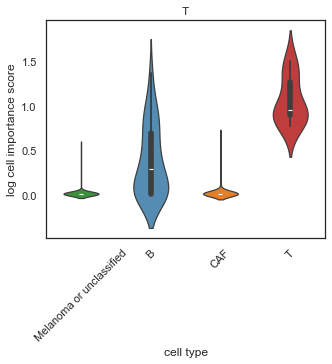

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
celltype = "T"
cells = pd.DataFrame(cell_importance[celltype], columns = ["cell_imp_score"])
min_val = cells[cells['cell_imp_score'] > 0]['cell_imp_score'].min()
cells['cell_imp_score'] = cells['cell_imp_score'].apply(lambda x: x + min_val/2)
cells['cell_imp_score']= np.log10(cells['cell_imp_score']+1)
# Log normalization
cells['cell_type'] = np.array(adata.obs['celltype'])
df = cells
sns.set_theme(style='white')
palette={
    "B":"#468fc1",
    "CAF":"#ff7e0d",
    "Melanoma or unclassified":"#2ea02e",
    "T":"#d62728"
}
plt.figure(figsize=(5, 4))
ax = sns.violinplot(data=df, width=0.5, density_norm='count', x='cell_type', y='cell_imp_score', palette=palette)
plt.xticks(rotation=45)

ax.set_title(celltype)
ax.set(xlabel='cell type', ylabel='log cell importance score')

plt.show()

In [10]:
from utils.utils import findSigGenes

labels = np.array(adata.obs['celltype'])
important_genes_cluster = findSigGenes(gene_importance, labels, genes_interest)

In [46]:
important_genes = set()
for cluster in clusters:
    important_genes.update(important_genes_cluster[cluster]['significant_genes'])
    
lr_enriched = lr_enriched.loc[
    lr_enriched['ligand'].isin(important_genes) & lr_enriched['receptor'].isin(important_genes)
]

In [47]:
important_genes = set()
for cluster in clusters:
    important_genes.update(important_genes_cluster[cluster]['significant_genes'])
    
lr_enriched = lr_enriched.loc[
    lr_enriched['ligand'].isin(important_genes) & lr_enriched['receptor'].isin(important_genes)
]

In [ ]:
from utils.lr_analysis import *

lr_genes = np.unique(lr_enriched[['ligand', 'receptor']].values)

sig_score = np.zeros(shape=(adata.shape[0], len(lr_genes)))

labels = np.array(adata.obs['celltype'])
clusters = np.unique(labels)

lr_genes_idx = np.vectorize(maps.get)(lr_genes)
for cluster in clusters:
    target_indices = (labels == cluster)
    gene_importance_score = gene_importance[cluster][target_indices, :]
    gene_importance_score = gene_importance_score[:, lr_genes_idx]
    sig_score[target_indices, :] = gene_importance_score
    
sig_score = pd.DataFrame(sig_score, columns=lr_genes)

In [44]:

w_best = default_w_visium(adata)
dist_factor_mat = dist_factor_calculate(adata, w_best=w_best )

celltype_cci = getCelltypeInteraction(sig_score, lr_enriched, clusters, clusters, labels, dist_factor_mat)

In [ ]:
output_dir = os.path.join("./output", "mel_data")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
celltype_cci.to_csv(os.path.join(output_dir, "celltype_cci.csv"))